# STA9131 Assignment 4-2: Two-Stage Object Detector

Before we start, please put your name and ID number in following format: e.g., <br>
```
name = 'Kibok Lee'
idnum = '2022123456'
```

In [1]:
# TODO: Put your name and id number:
name = 'Insik Cho'
idnum = '2021321148'

In this exercise, you will implement a **two-stage** object detector, based on [Faster R-CNN](https://arxiv.org/pdf/1506.01497.pdf), which consists of two modules - Region Proposal Networks (RPN) and Fast R-CNN.
We will train it to detect a set of object classes and evaluate the detection accuracy using the classic metric mean Average Precision ([mAP](https://github.com/Cartucho/mAP)).

# Setup Code
Before getting started, we need to run some boilerplate code to set up our environment, same as previous assignments. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [2]:
%load_ext autoreload
%autoreload 2

## Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [3]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the following cell should print the filenames from the assignment:

```
['a4_helper.py', 'common', 'pytorch_autograd_and_nn.ipynb', 'pytorch_autograd_and_nn.py', 'two_stage_detector.ipynb', 'two_stage_detector.py']
```

In [4]:
import os
import sys

# TODO: Fill in the Google| Drive path where you uploaded the assignment
# Example: If you create a STA9131 folder and put all the files under A4 folder, then 'STA9131/A4'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '/content/drive/MyDrive/연세대/시각인식/A4'
GOOGLE_DRIVE_PATH = os.path.join("drive", "MyDrive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(sorted(os.listdir(GOOGLE_DRIVE_PATH)))


# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['VOCtrainval_06-Nov-2007.tar', '__pycache__', 'a4_helper.py', 'common', 'insik_cho-2021321148-A4.zip', 'pytorch_autograd_and_nn.ipynb', 'pytorch_autograd_and_nn.pt', 'pytorch_autograd_and_nn.py', 'rcnn_detector.pt', 'two_stage_detector.ipynb', 'two_stage_detector.py', 'two_stage_detector.py의 사본', 'two_stage_detector_살짝수정.py', 'voc07_train.json', 'voc07_val.json']


Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from two_stage_detector.py!
Hello from a4_helper.py!
```

as well as the last edit time for the file `two_stage_detector.py`.

In [5]:
import os
import time

os.environ["TZ"] = "Asia/Seoul"
time.tzset()

from two_stage_detector import hello_two_stage_detector
hello_two_stage_detector()

from a4_helper import hello_helper
hello_helper()

two_stage_detector_path = os.path.join(GOOGLE_DRIVE_PATH, "two_stage_detector.py")
two_stage_detector_edit_time = time.ctime(os.path.getmtime(two_stage_detector_path))
print("two_stage_detector.py last edited on %s" % two_stage_detector_edit_time)

Hello from two_stage_detector.py!
Hello from a4_helper.py!
two_stage_detector.py last edited on Mon May 30 22:03:31 2022


Load several useful packages that are used in this notebook:

In [6]:
import os
import time

import matplotlib.pyplot as plt
import torch
import torchvision

%matplotlib inline

from a4_helper import *
from common import reset_seed
from common.grad import rel_error

# for plotting
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["font.size"] = 16
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

# To download the dataset
!pip install wget

# for mAP evaluation
!rm -rf mAP
!git clone https://github.com/Cartucho/mAP.git
!rm -rf mAP/input/*

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Total 908 (delta 0), reused 0 (delta 0), pack-reused 908
Receiving objects: 100% (908/908), 14.71 MiB | 21.28 MiB/s, done.
Resolving deltas: 100% (321/321), done.


We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [7]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    DEVICE = torch.device("cpu")

Good to go!


# Load PASCAL VOC 2007 data
During the majority of our homework assignments so far, we have used the CIFAR-10 dataset for image classification tasks.

In order to train and evaluate object detection models, we need a dataset where each image is annotated with a *set* of *bounding boxes*, where each box gives the category label and spatial extent of some object in the image.

We will use the [PASCAL VOC 2007](http://host.robots.ox.ac.uk/pascal/VOC/) dataset, which provides annotations of this form. PASCAL VOC ran a series of yearly computer vision competitions from 2005 to 2012, predating the ImageNet challenge which we have discussed in class.
The data from the 2007 challenge used to be one of the most popular datasets for evaluating object detection.
It is much smaller than more recent object detection datasets such as [COCO](http://cocodataset.org/#home), and thus easier to manage in an homework assignment.
VOC comprises annotated bounding boxes for 20 object classes:
`["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]`.

We create a [`PyTorch Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class
named `VOC2007DetectionTiny` in `a4_helper.py` will download the PASCAL VOC 2007 dataset.
This class returns annotations for each image as a nested set of dictionary objects.

Run the following two cells to set a few config parameters and then download the train/val sets for the PASCAL VOC 2007 dataset.

In [8]:
import multiprocessing

# Set a few constants related to data loading.
NUM_CLASSES = 20
BATCH_SIZE = 16
IMAGE_SHAPE = (224, 224)
NUM_WORKERS = multiprocessing.cpu_count()
DATA_ROOT = "./here"

## NOTE: You should not hard-code any of these above values in your implementation.

For example, do not use the value "224" while performing any view operations with image features or such. We may test your implementation with different image sizes, batch sizes and dataset subsets.
They would of course yield different final accuracies and that's expected, but your code should not error when grading.
As with prior assignments, write dtype and device agnostic code.
Use `DEVICE` constant like we did in previous cell.


## Download the dataset first.

We provide images and pre-processed annotation files here. They need to be in `DATA_ROOT` the following directory structure:

```bash
DATA_ROOT
    - VOCdevkit/   # Extracted from `VOCtrainval_06-Nov-2007.tar
        - VOC2007/
            - JPEGImages/
            # Other directories like `SegmentationClass`, `SegmentationObject` etc. are not needed
```

The following cell can download them automatically for you.
However, Colab may hang indefinitely sometimes. We do not have a clear reason for why that happens.
In that case, you may download the tar file manually on your machine, upload them to `GOOGLE_DRIVE_PATH`, and run the following cell again.
This command will work for for Linux/Mac:

```
wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
```

In [9]:
from a4_helper import VOC2007DetectionTiny

# NOTE: Set `download=True` for the first time when you set up Google Drive folder.
# If this hangs, download and place the tar file in your drive manually as shown above.
train_dataset = VOC2007DetectionTiny(
    GOOGLE_DRIVE_PATH, "train", image_size=IMAGE_SHAPE[0], tmp_dir=DATA_ROOT,
    download=True
)
val_dataset = VOC2007DetectionTiny(
    GOOGLE_DRIVE_PATH, "val", image_size=IMAGE_SHAPE[0], tmp_dir=DATA_ROOT,
)

print(f"Dataset sizes: train ({len(train_dataset)}), val ({len(val_dataset)})")

Dataset sizes: train (2501), val (2510)




```
# This is formatted as code
```

To train our detector, we need to convert individual images (JPEG) and annotations (XML files) into batches of tensors. We perform this by wrapping our datasets with a PyTorch [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) object.
We have implemented it in `a4_helper.py` - you are not required to understand its implementation, however you should understand the format of its output (which we will explore next).

In [10]:
# `pin_memory` speeds up CPU-GPU batch transfer, `num_workers=NUM_WORKERS` loads data
# on the main CPU process, suitable for Colab.
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NUM_WORKERS
)

# Use batch_size = 1 during inference - during inference we do not center crop
# the image to detect all objects, hence they may be of different size. It is
# easier and less redundant to use batch_size=1 rather than zero-padding images.
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, pin_memory=True, num_workers=NUM_WORKERS
)

The `DataLoader` objects return batches of data.

The first output from the `DataLoader` is a Tensor `image` of shape `(B, 3, IMAGE_SHAPE[0], IMAGE_SHAPE[1])`. This is a batch of `B` images, similar to what we have seen in classification datasets.

The second output from the `DataLoader` is a Tensor `gt_boxes` of shape `(B, N, 5)` giving information about all objects in all images of the batch. `gt_boxes[i, j] = (x1, y1, x2, y2, C)` gives information about the `j`th object in `image[i]`. The position of the top-left corner of the box is `(x1, y1)` and the position of the bottom-right corner of the box is `(x2, x2)`. These coordinates are real-valued in `[0, 224]`. `C` is an integer giving the category label for this bounding box. This `(x1, y1, x2, y2)` format for bounding boxes is commonly referred as XYXY format.

Each image can have different numbers of objects. If `image[i]` has $N_i$ objects, then $N = \max_i(N_i)$ is the maximum number of objects per image among all objects in the batch; this value can vary from batch to batch. For the images that have fewer than $N$ annotated objects, only the first $N_i$ rows of `gt_boxes[i]` contain annotations; the remaining rows are padded with -1.

In [11]:
train_loader_iter = iter(train_loader)
image_paths, images, gt_boxes = train_loader_iter.next()

print(f"image paths           : {image_paths}")
print(f"image batch has shape : {images.shape}")
print(f"gt_boxes has shape    : {gt_boxes.shape}")

print(f"4 boxes for the first 3 images:")
print(gt_boxes[:3, :4, :])

image paths           : ['./here/VOCdevkit/VOC2007/JPEGImages/000012.jpg', './here/VOCdevkit/VOC2007/JPEGImages/000017.jpg', './here/VOCdevkit/VOC2007/JPEGImages/000023.jpg', './here/VOCdevkit/VOC2007/JPEGImages/000026.jpg', './here/VOCdevkit/VOC2007/JPEGImages/000032.jpg', './here/VOCdevkit/VOC2007/JPEGImages/000033.jpg', './here/VOCdevkit/VOC2007/JPEGImages/000034.jpg', './here/VOCdevkit/VOC2007/JPEGImages/000035.jpg', './here/VOCdevkit/VOC2007/JPEGImages/000036.jpg', './here/VOCdevkit/VOC2007/JPEGImages/000042.jpg', './here/VOCdevkit/VOC2007/JPEGImages/000044.jpg', './here/VOCdevkit/VOC2007/JPEGImages/000047.jpg', './here/VOCdevkit/VOC2007/JPEGImages/000048.jpg', './here/VOCdevkit/VOC2007/JPEGImages/000061.jpg', './here/VOCdevkit/VOC2007/JPEGImages/000064.jpg', './here/VOCdevkit/VOC2007/JPEGImages/000066.jpg']
image batch has shape : torch.Size([16, 3, 224, 224])
gt_boxes has shape    : torch.Size([16, 40, 5])
4 boxes for the first 3 images:
tensor([[[ 48.9369,  65.2493, 180.1081, 1

## Visualize PASCAL VOC 2007

Before starting to build your model, it is highly recommended that you visualize your training data and observe some examples. This can help uncover any bugs in dataloading and sometimes even give you strong intuitions to include a modeling component!

We also use a function to visualize our detections, implemented in `common/utils.py`. You are not required to understand it but we encourage you to read it! Here we sample some images from the PASCAL VOC 2007 training set, and visualize the ground-truth object boxes and category labels:

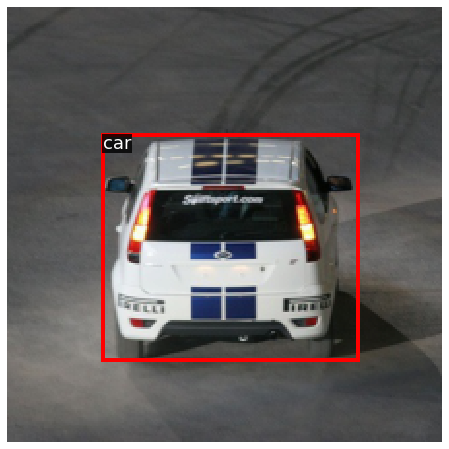

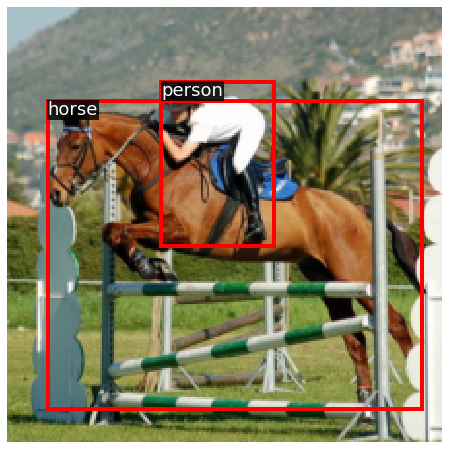

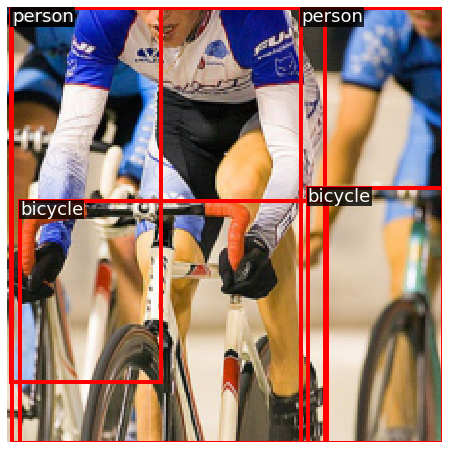

In [12]:
from torchvision import transforms
from common.utils import detection_visualizer

# Define an "inverse" transform for the image that un-normalizes by ImageNet color
# and mean. Without this, the images will NOT be visually understandable.
inverse_norm = transforms.Compose(
    [
        transforms.Normalize(mean=[0., 0., 0.], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
    ]
)

for idx, (_, image, gt_boxes) in enumerate(train_dataset):
    # Stop after visualizing three images.
    if idx > 2:
        break

    # Un-normalize image to bring in [0, 1] RGB range.
    image = inverse_norm(image)

    # Remove padded boxes from visualization.
    is_valid = gt_boxes[:, 4] >= 0
    detection_visualizer(image, val_dataset.idx_to_class, gt_boxes[is_valid])

# Implementing Backbone with Feature Pyramid Networks (FPN)

First, we start building the backbone and FPN of our detector. It is the core component that takes in an image and outputs its features of different scales. It can be any type of convolutional network that progressively downsamples the image (e.g. via intermediate max pooling).

Here, we use a small [RegNetX-400MF](https://pytorch.org/vision/stable/models.html#torchvision.models.regnet_x_400mf) as the backbone so we can train in reasonable time on Colab. We have already implemented the minimal logic to initialize this backbone from pre-trained ImageNet weights and extract intermediate features `(c3, c4, c5)` as shown in the figure above.
These features `(c3, c4, c5)` have height and width that is ${1/8}^{th}$, ${1/16}^{th}$, and ${1/32}^{th}$ of the input image respectively.
These values `(8, 16, 32)` are called the "stride" of these features.
In other words, it means that moving one location on the FPN level is equivalent to moving `stride` pixels in the input image.

You need to implement extra modules to attach the FPN to this backbone. For more details, see Figure 3 in [FPN paper](https://arxiv.org/abs/1612.03144).
FPN will convert these `(c3, c4, c5)` multi-scale features to `(p3, p4, p5)`. These notations "p3", "p4", "p5" are called _FPN levels_.
Before you write any code, let's initialize the backbone in the next cell. You should see the shape of `(c3, c4, c5)` features for an input image.

**NOTE:** Typical state-of-the-art detectors based on Faster R-CNN use four multi-scale features from different FPN levels — `(p2, p3, p4, p5)` with strides `(4, 8, 16, 32)`.
Due to computational limits of Google Colab, we will instead simply use `(p3, p4, p5)` features.
In all your implementations for this part, you may assume that you will receive features from these three FPN levels (and may hard-code these names as Python strings). Your code will not be tested with `p2` FPN features and you will not lose points.

In [13]:
import torch
from two_stage_detector import DetectorBackboneWithFPN

backbone = DetectorBackboneWithFPN(out_channels=64)

For dummy input images with shape: (2, 3, 224, 224)
Shape of c3 features: torch.Size([2, 64, 28, 28])
Shape of c4 features: torch.Size([2, 160, 14, 14])
Shape of c5 features: torch.Size([2, 400, 7, 7])


Follow the instructions in `two_stage_detector.py` to implement additional FPN layers for transforming `(c3, c4, c5)` to `(p3, p4, p5)`.
For training a small enough model on Google Colab, we leave out `(p6, p7)` as shown in the Figure.
Output features from these FPN levels are expected to have same height and width as backbone features, but now they should have the same number of channels.

In [14]:
print("Extra FPN modules added:")
print(backbone.fpn_params)

# Pass a batch of dummy images (random tensors) in NCHW format and observe the output.
dummy_images = torch.randn(2, 3, 224, 224)

# Collect dummy output.
dummy_fpn_feats = backbone(dummy_images)

print(f"For dummy input images with shape: {dummy_images.shape}")
for level_name, feat in dummy_fpn_feats.items():
    print(f"Shape of {level_name} features: {feat.shape}")

Extra FPN modules added:
ModuleDict(
  (cv5): Conv2d(400, 64, kernel_size=(1, 1), stride=(1, 1))
  (cv4): Conv2d(160, 64, kernel_size=(1, 1), stride=(1, 1))
  (cv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (cv_o5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cv_o4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cv_o3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
For dummy input images with shape: torch.Size([2, 3, 224, 224])
Shape of p3 features: torch.Size([2, 64, 28, 28])
Shape of p4 features: torch.Size([2, 64, 14, 14])
Shape of p5 features: torch.Size([2, 64, 7, 7])


# Faster R-CNN first stage: Region Proposal Network (RPN)

We will now implement the first-stage of Faster R-CNN. It comprises a **Region Proposal Network (RPN)** that learns to predict general _object proposals_, which will then be used by the second stage to make final predictions.

**RPN prediction:** An input image is passed through the backbone and we obtain its FPN feature maps `(p3, p4, p5)`.
The RPN predicts multiple values at _every location on FPN features_. Faster R-CNN is _anchor-based_ — the model assumes that every location has multiple pre-defined boxes (called "anchors") and it predicts two measures per anchor, per FPN location:

1. **Objectness:** The likelihood of having _any_ object inside the anchor, which is _class-agnostic_: it only performs binary foreground/background classification.
2. **Box regression deltas:** 4-D "deltas" that _transform_ an anchor at that location to a ground-truth box.

![pred_scores2](https://miro.medium.com/max/918/1*wB3ctS9WGNmw6pP_kjLjgg.png)

**SIDE NOTE:** We will use the more common practice of predicting `k` logits and use a logistic regressor instead of `2k` scores (and 2-way softmax) as shown in Figure. This slightly reduces the number of trainable parameters.

Each anchor will be matched with a GT box for supervision — we will get to it shortly.
For now, let's assume there are some `A` anchor boxes at every FPN location, and implement an RPN module.
Now follow the instructions in `RPNPredictionNetwork` of `two_stage_detector.py` and implement layers to predict objectness and box regression deltas.
Execute the following cell to test your implementation:

In [15]:
from two_stage_detector import RPNPredictionNetwork

rpn_pred_net = RPNPredictionNetwork(
    in_channels=64, stem_channels=[64], num_anchors=3
)

# Pass the dummy FPN feats to RPN prediction network and view its output shapes.
dummy_rpn_obj, dummy_rpn_box = rpn_pred_net(dummy_fpn_feats)

# Few expected outputs:
# Shape of p4 RPN objectness: torch.Size([2, 588])
# Shape of p5 RPN box deltas: torch.Size([2, 147, 4])

print(f"\nFor dummy input images with shape: {dummy_images.shape}")
for level_name in dummy_fpn_feats.keys():
    print(f"Shape of {level_name} FPN features  : {dummy_fpn_feats[level_name].shape}")
    print(f"Shape of {level_name} RPN objectness: {dummy_rpn_obj[level_name].shape}")
    print(f"Shape of {level_name} RPN box deltas: {dummy_rpn_box[level_name].shape}")
    print("")


For dummy input images with shape: torch.Size([2, 3, 224, 224])
Shape of p3 FPN features  : torch.Size([2, 64, 28, 28])
Shape of p3 RPN objectness: torch.Size([2, 2352])
Shape of p3 RPN box deltas: torch.Size([2, 2352, 4])

Shape of p4 FPN features  : torch.Size([2, 64, 14, 14])
Shape of p4 RPN objectness: torch.Size([2, 588])
Shape of p4 RPN box deltas: torch.Size([2, 588, 4])

Shape of p5 FPN features  : torch.Size([2, 64, 7, 7])
Shape of p5 RPN objectness: torch.Size([2, 147])
Shape of p5 RPN box deltas: torch.Size([2, 147, 4])



## Anchor-based Training of RPN

Now that we implemented the RPN head, our goal is to have it predict _high objectness_ and _accurate box deltas_ for anchors that are likely to contain objects.
Similar to first part of our assignment, we need to assign a target GT box to every RPN prediction for training supervision.

Faster R-CNN is anchor-based: instead of _locations_, it makes predictions with reference to some pre-defined _anchor boxes_, and matches each anchor with a single GT box if they have a high enough Intersection-over-Union (IoU).

In the next few cells, we will perform the following steps:

1. **Anchor generation:** Generate a set of anchors for every location in FPN feature map.
2. **Anchor to GT matching:** Match these anchors with GT boxes based on their IoU-overlap.
3. **Format of box deltas:** Implement the tranformation functions to obtain _box deltas_ from GT boxes (model training supervision) and apply deltas to anchors (final proposal boxes for second stage).

Let's approach these steps, one by one.

### Mapping every location in FPN feature map to the image

Before generating anchors in FPN feature maps, we need to map every location (pixel) in FPN feature map to a point on the image. This point represents the center of the receptive field of this location.

GT boxes are available (from the dataloader) as 5D vectors `(x1, y1, x2, y2, C)` where `(x1, y1)` is the top-left co-ordinate and `(x2, y2)` is the bottom-right co-ordinate of the bounding box, and `C` is its object class label. These co-ordinates are absolute and real-valued in image dimensions. To begin with the assignment, we will represent every location on an FPN level with `(xc, yc)` absolute and real-valued co-ordinates of a point on the image, that are centers of the receptive fields of those features.

For example, given features from FPN level having shape `(batch_size, channels, H / stride, W / stride)` and the location `feature[:, :, i, j]` will map to the image pixel `(stride * (i + 0.5), stride * (j + 0.5))` - 0.5 indicates the shift from top-left corner to the center of "stride box".

Implement the `get_fpn_location_coords` in `two_stage_detector.py` to get `(xc, yc)` location co-ordinates of all FPN features. Follow its documentation and see its usage example in the following cell. If you implemented correctly, you will see point grids with different strides on an image.

First five locations per FPN level (absolute image co-ordinates):
p3: [[4.0, 4.0], [12.0, 4.0], [20.0, 4.0], [28.0, 4.0], [36.0, 4.0]]
rel error:  0.0
p4: [[8.0, 8.0], [24.0, 8.0], [40.0, 8.0], [56.0, 8.0], [72.0, 8.0]]
rel error:  0.0
p5: [[16.0, 16.0], [48.0, 16.0], [80.0, 16.0], [112.0, 16.0], [144.0, 16.0]]
rel error:  0.0
********************************************************************************
All locations of the image FPN level = p3
stride = 8


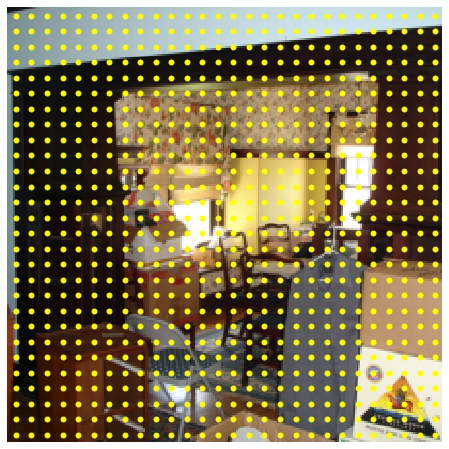

********************************************************************************
All locations of the image FPN level = p4
stride = 16


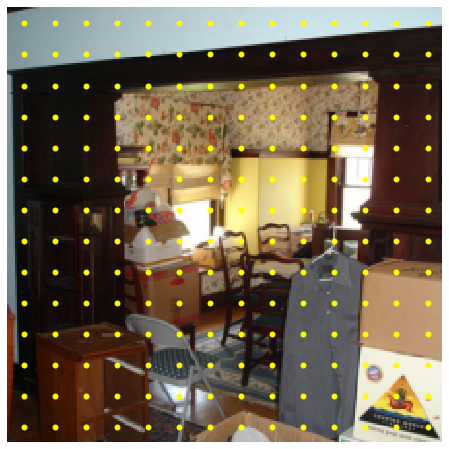

********************************************************************************
All locations of the image FPN level = p5
stride = 32


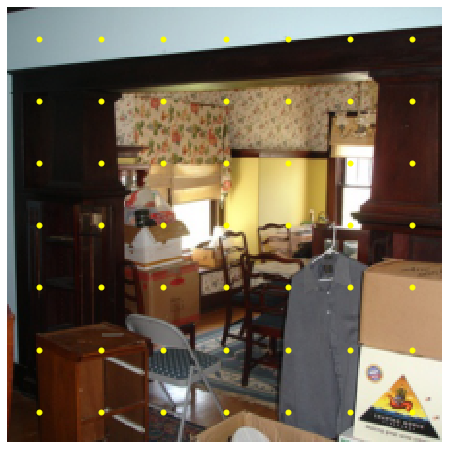

In [16]:
from two_stage_detector import get_fpn_location_coords

# Get shapes of each FPN level feature map. We don't call these "dummy" because
# they don't depend on the _values_ of features, but rather only shapes.
fpn_feats_shapes = {
    level_name: feat.shape for level_name, feat in dummy_fpn_feats.items()
}

# Get CPU tensors for this sanity check: (you can pass `device=` argument.
locations_per_fpn_level = get_fpn_location_coords(fpn_feats_shapes, backbone.fpn_strides)

# First five location co-ordinates for each feature maps.
expected_locations = {
    "p3": torch.tensor([[4.0, 4.0], [12.0, 4.0], [20.0, 4.0], [28.0, 4.0], [36.0, 4.0]]),
    "p4": torch.tensor([[8.0, 8.0], [24.0, 8.0], [40.0, 8.0], [56.0, 8.0], [72.0, 8.0]]),
    "p5": torch.tensor([[16.0, 16.0], [48.0, 16.0], [80.0, 16.0], [112.0, 16.0], [144.0, 16.0]]),
}

print("First five locations per FPN level (absolute image co-ordinates):")
for level_name, locations in locations_per_fpn_level.items():
    print(f"{level_name}: {locations[:5, :].tolist()}")
    print("rel error: ", rel_error(expected_locations[level_name], locations[:5, :]))

# Visualize all the locations on first image from training data.
for level_name, locations in locations_per_fpn_level.items():
    # Un-normalize image to bring in [0, 1] RGB range.
    image = inverse_norm(val_dataset[0][1])

    print("*" * 80)
    print(f"All locations of the image FPN level = {level_name}")
    print(f"stride = {backbone.fpn_strides[level_name]}")
    detection_visualizer(image, val_dataset.idx_to_class, points=locations.tolist())

### Anchor Generation

For anchor generation, first we need to form multiple anchor boxes centered at these locations.
RPN defines square anchor boxes of size `scale * stride` at every location, where `stride` is the FPN level stride, and `scale` is a hyperparameter.
For example, anchor boxes for P5 level (`stride = 32`), with `scale = 2` will be boxes of `(64 x 64)` pixels.
RPN also considers anchors of different aspect ratios, apart from square anchor boxes —
follow the instructions in `generate_fpn_anchors` of `two_stage_detector.py` to implement creation of multiple anchor boxes per location.

Execute the next cell to verify your implementation — you should observe an error of `1e-6` or less.

In [17]:
from two_stage_detector import get_fpn_location_coords, generate_fpn_anchors


# Sanity check: Get 2x2 location co-ordinates of p5 (original shape is 7x7).
locations = get_fpn_location_coords(
    shape_per_fpn_level={"p5": (2, 64, 2, 2)}, strides_per_fpn_level={"p5": 32}
)

print("P5 locations:\n", locations["p5"])

# Generate anchors for these locations.
anchors = generate_fpn_anchors(
    locations_per_fpn_level=locations,
    strides_per_fpn_level={"p5": 32},
    stride_scale=2,
    aspect_ratios=[0.5, 1.0, 2.0],
)

print("P5 anchors with different aspect ratios:")
correct_out = torch.tensor([[-29.2548,  -6.6274,  61.2548,  38.6274],
                            [  2.7452,  -6.6274,  93.2548,  38.6274],
                            [-29.2548,  25.3726,  61.2548,  70.6274],
                            [  2.7452,  25.3726,  93.2548,  70.6274]])
print("P5 1:2 anchors rel error: ", rel_error(anchors["p5"][0::3, :], correct_out))

correct_out = torch.tensor([[-16., -16.,  48.,  48.],
                            [ 16., -16.,  80.,  48.],
                            [-16.,  16.,  48.,  80.],
                            [ 16.,  16.,  80.,  80.]],
                           dtype=torch.float64)
print("P5 1:1 anchors rel error: ", rel_error(anchors["p5"][1::3, :], correct_out))

correct_out = torch.tensor([[ -6.6274, -29.2548,  38.6274,  61.2548],
                            [ 25.3726, -29.2548,  70.6274,  61.2548],
                            [ -6.6274,   2.7452,  38.6274,  93.2548],
                            [ 25.3726,   2.7452,  70.6274,  93.2548]])
print("P5 2:1 anchors rel error: ", rel_error(anchors["p5"][2::3, :], correct_out))

P5 locations:
 tensor([[16., 16.],
        [48., 16.],
        [16., 48.],
        [48., 48.]])
P5 anchors with different aspect ratios:
P5 1:2 anchors rel error:  2.0453083245030555e-07
P5 1:1 anchors rel error:  0.0
P5 2:1 anchors rel error:  2.0453083245030555e-07


### Matching anchor boxes with GT boxes

We will now match these generated anchors with GT boxes. Faster R-CNN matches some `N` anchor boxes with `M` GT boxes by applying a simple rule:

> Anchor box $N_i$ is matched with box $M_i$ if it has an IoU overlap higher than 0.6 with that box. For multiple such GT boxes, the anchor is assigned with the GT box that has the highest IoU. Note that a single ground-truth box may assign positive labels to multiple anchors.

**NOTE:** _Faster R-CNN uses 0.7 default threshold_ as mentioned in the lecture slides. We use a lower threshold to increase the number of positive matches for sampling — this helps in speeding up training in a resource constrained setting like Google Colab.

Anchor boxes with `IoU < 0.3` with ALL GT boxes is assigned background GT box `(-1, -1, -1, -1, -1)`. All other anchors with IoU between `(0.3, 0.6)` are considered "neutral" and ignored during training. In fact, the "neutral" Faster R-CNN anchors cause wasted computation, and removing this redundancy would overly complicate our implementation.

We have implemented this matching procedure for you — see `rcnn_match_anchors_to_gt` of `two_stage_detector.py`.
Read its documentation to understand its input/output format.
It defines GT targets for model predictions during training.

This function internally requires IoU computation between all anchors and GT boxes — which you have to implement.
Follow the instructions in `two_stage_detector.py` to implement IoU computation, and execute the next cell for a sanity check — you should observe an error of `1e-7` or less.

In [18]:
import torch
from two_stage_detector import iou


boxes1 = torch.Tensor([[10, 10, 90, 90], [20, 20, 40, 40], [60, 60, 80, 80]])
boxes2 = torch.Tensor([[10, 10, 90, 90], [60, 60, 80, 80], [30, 30, 70, 70]])

expected_iou = torch.Tensor(
    [[1.0, 0.0625, 0.25], [0.0625, 0.0, 0.052631579], [0.0625, 1.0, 0.052631579]]
)
result_iou = iou(boxes1, boxes2)

print("Relative error:", rel_error(expected_iou, result_iou))

Relative error: 0.0


### Visualizing matched GT boxes

Now we apply our anchor matching function and visualize one GT box with a random matched positive anchor box.
You may try different images by indexing `train_dataset` below,
make sure to try different FPN levels as certain images may not get any matched GT boxes due to their size.

Unlabeled red box is positive anchor:


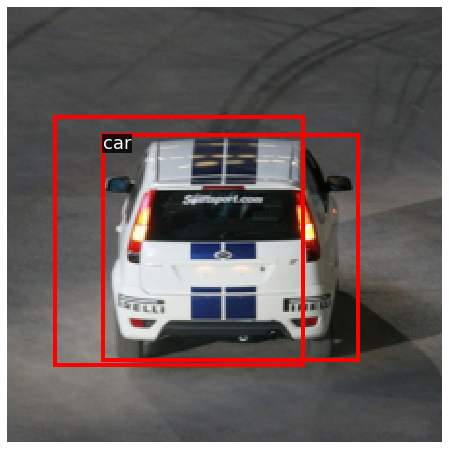

In [19]:
import random
from two_stage_detector import get_fpn_location_coords, generate_fpn_anchors, rcnn_match_anchors_to_gt


# Sanity check: Match anchors of p4 level with GT boxes of first image
# in the training dataset.
_, image, gt_boxes = train_dataset[0]

FPN_LEVEL = "p4"
FPN_STRIDE = 16
locations = get_fpn_location_coords(
    shape_per_fpn_level={FPN_LEVEL: (2, 64, 224 // FPN_STRIDE, 224 // FPN_STRIDE)},
    strides_per_fpn_level={FPN_LEVEL: FPN_STRIDE}
)
# Generate anchors for these locations.
anchors = generate_fpn_anchors(
    locations_per_fpn_level=locations,
    strides_per_fpn_level={FPN_LEVEL: FPN_STRIDE},
    stride_scale=8,  # Default value used by Faster R-CNN
    aspect_ratios=[0.5, 1.0, 2.0],
)

matched_gt_boxes = rcnn_match_anchors_to_gt(
    anchors[FPN_LEVEL], gt_boxes, iou_thresholds=(0.3, 0.6)
)

# Flatten anchors and matched boxes:
anchors_p4 = anchors[FPN_LEVEL].view(-1, 4)
matched_boxes_p4 = matched_gt_boxes.view(-1, 5)

# Visualize one selected anchor and its matched GT box.
# NOTE: Run this cell multiple times to see different matched anchors. For car
# image, p3/5 will not work because the GT box was already assigned to p4.
fg_idxs_p4 = (matched_boxes_p4[:, 4] > 0).nonzero()
fg_idx = random.choice(fg_idxs_p4)

# Combine both boxes for visualization:
dummy_vis_boxes = [anchors_p4[fg_idx][0], matched_boxes_p4[fg_idx][0]]

print("Unlabeled red box is positive anchor:")
detection_visualizer(
    inverse_norm(image),
    val_dataset.idx_to_class,
    bbox=dummy_vis_boxes,
)

### GT Targets for box regression

Now we work on the third and final component needed to train our RPN — we define transformation functions for box regression deltas.

Here you will implement transformation functions for R-CNN. You will find these transforms in slide 36 in Lecture 13 rev1, follow these and implement two functions in `two_stage_detector.py`:

1. `rcnn_get_deltas_from_anchors`: Accepts anchor boxes and GT boxes, and returns deltas. Required for training supervision.
2. `rcnn_apply_deltas_to_anchors`: Accepts predicted deltas and anchor boxes, and returns predicted boxes. Required during inference.

Run the following cell to check your implementation.

In [20]:
import torch
from two_stage_detector import rcnn_get_deltas_from_anchors, rcnn_apply_deltas_to_anchors

# Three hard-coded anchor boxes and GT boxes that have a fairly high overlap.
# Add a dummy class ID = 1 indicating foreground
input_anchors = torch.Tensor(
    [[20, 40, 80, 90], [10, 10, 50, 50], [120, 100, 200, 200]]
)
input_boxes = torch.Tensor(
    [[10, 15, 100, 115, 1], [30, 20, 40, 30, 1], [120, 100, 200, 200, 1]]
)

# Here we do a simple sanity check - getting deltas for a particular set of boxes
# and applying them back to anchors should give us the same boxes.
_deltas = rcnn_get_deltas_from_anchors(input_anchors, input_boxes)
output_boxes = rcnn_apply_deltas_to_anchors(_deltas, input_anchors)

print("Rel error in reconstructed boxes:", rel_error(input_boxes[:, :4], output_boxes))

# Another check: deltas for GT class label = -1 should be -1e8
background_box = torch.Tensor([[-1, -1, -1, -1, -1]])
input_anchor = torch.Tensor([[100, 100, 200, 200]])

_deltas = rcnn_get_deltas_from_anchors(input_anchor, background_box)
output_box = rcnn_apply_deltas_to_anchors(_deltas, input_anchor)

print("Background deltas should be all -1e8  :", _deltas)
print("Output box should be -1e8 or lower    :", output_box)

Rel error in reconstructed boxes: 0.0
Background deltas should be all -1e8  : tensor([[-100000000., -100000000., -100000000., -100000000.]])
Output box should be -1e8 or lower    : tensor([[-1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10]])


## Loss Functions

With all predictions assigned with GT targets, we will proceed to compute losses for training the RPN.

**Objectness classification loss:** Faster R-CNN dealt with class imbalance by randomly sampling roughly equal amount of foreground-background anchors to train RPN. We have implemented a very simple sampling function for you in `sample_rpn_training` function of `two_stage_detector.py` — you may directly use it while you piece all these components (coming up next).

**Total loss** is the sum of both loss components _per sampled anchor_, averaged by total number of foreground + background anchors.

Execute the next cell to check their usage.

In [21]:
import torch
from torch.nn import functional as F


# Sanity check: dummy predictions from model - box regression deltas and
# objectness logits for two anchors.
# shape: (batch_size, HWA, 4 or 1)
dummy_pred_boxreg_deltas = torch.randn(1, 2, 4)
dummy_pred_obj_logits = torch.randn(1, 2, 1)

# Dummy deltas and objectness targets. Let the second box be background.
# Dummy GT boxes (matched with both anchors).
dummy_gt_deltas = torch.randn_like(dummy_pred_boxreg_deltas)
dummy_gt_deltas[:, 1, :] = -1e8

# Background objectness targets should be 0 (not -1), and foreground
# should be 1. Neutral anchors will not occur here due to sampling.
dummy_gt_objectness = torch.Tensor([1, 0])

# L1 loss:
loss_box = F.l1_loss(
    dummy_pred_boxreg_deltas, dummy_gt_deltas, reduction="none"
)

# No loss for background anchors:
loss_box[dummy_gt_deltas == -1e8] *= 0.0
print("Box regression loss (L1):", loss_box)

# Now calculate objectness loss.
loss_obj = F.binary_cross_entropy_with_logits(
    dummy_pred_obj_logits.view(-1), dummy_gt_objectness, reduction="none"
)
print("Objectness loss (BCE):", loss_obj)

Box regression loss (L1): tensor([[[0.2368, 0.4027, 0.3155, 0.6758],
         [0.0000, 0.0000, 0.0000, 0.0000]]])
Objectness loss (BCE): tensor([0.7169, 0.7700])


## Putting it all together: RPN module

Now you will put together all the things you have implemented into the `RPN` class in `two_stage_detector.py`.
Implement `forward` and `predict_proposals` functions of this module — you have already done most of the heavy lifting, you simply need to call all the functions in a correct way!
Use the previous two cells as a reference to implement loss calculation in `forward()`.

## Overfit small data

In Faster R-CNN, the RPN is trained jointly with the second-stage network.
However, to test our RPN implementation, we will first train the RPN only.
To do this, we will use the `train_detector` function in `a4_helper.py`.
You can read its implementation in `a4_helper.py`.

**Caution: This takes a long time! (~ 8 mins)**

For dummy input images with shape: (2, 3, 224, 224)
Shape of c3 features: torch.Size([2, 64, 28, 28])
Shape of c4 features: torch.Size([2, 160, 14, 14])
Shape of c5 features: torch.Size([2, 400, 7, 7])
[Iter 0][loss: 0.969][loss_rpn_obj: 0.692][loss_rpn_box: 0.278]
[Iter 20][loss: 0.932][loss_rpn_obj: 0.679][loss_rpn_box: 0.252]
[Iter 40][loss: 0.921][loss_rpn_obj: 0.669][loss_rpn_box: 0.252]
[Iter 60][loss: 0.901][loss_rpn_obj: 0.648][loss_rpn_box: 0.252]
[Iter 80][loss: 0.890][loss_rpn_obj: 0.639][loss_rpn_box: 0.251]
[Iter 100][loss: 0.878][loss_rpn_obj: 0.629][loss_rpn_box: 0.249]
[Iter 120][loss: 0.786][loss_rpn_obj: 0.536][loss_rpn_box: 0.250]
[Iter 140][loss: 0.792][loss_rpn_obj: 0.543][loss_rpn_box: 0.250]
[Iter 160][loss: 0.734][loss_rpn_obj: 0.478][loss_rpn_box: 0.257]
[Iter 180][loss: 0.609][loss_rpn_obj: 0.349][loss_rpn_box: 0.260]
[Iter 200][loss: 0.544][loss_rpn_obj: 0.297][loss_rpn_box: 0.247]
[Iter 220][loss: 0.589][loss_rpn_obj: 0.343][loss_rpn_box: 0.246]
[Iter 240][l

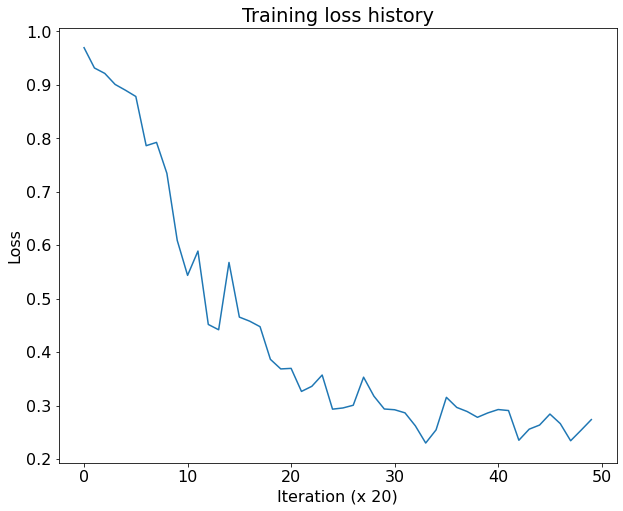

In [22]:
from torch import nn

from a4_helper import train_detector
from two_stage_detector import DetectorBackboneWithFPN, RPN

reset_seed(0)

# Take equally spaced examples from training dataset to make a subset.
small_dataset = torch.utils.data.Subset(
    train_dataset,
    torch.linspace(0, len(train_dataset) - 1, steps=BATCH_SIZE * 10).long()
)
small_train_loader = torch.utils.data.DataLoader(
    small_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NUM_WORKERS
)

# Create a wrapper module to contain backbone + RPN:
class FirstStage(nn.Module):
    def __init__(self, fpn_channels: int):
        super().__init__()
        self.backbone = DetectorBackboneWithFPN(out_channels=fpn_channels)
        self.rpn = RPN(
            fpn_channels=fpn_channels,
            # Simple stem of two layers:
            stem_channels=[fpn_channels, fpn_channels],
            batch_size_per_image=16,
            anchor_stride_scale=8,
            anchor_aspect_ratios=[0.5, 1.0, 2.0],
            anchor_iou_thresholds=(0.3, 0.6),
        )

    def forward(self, images, gt_boxes=None):
        feats_per_fpn_level = self.backbone(images)
        return self.rpn(feats_per_fpn_level, self.backbone.fpn_strides, gt_boxes)


first_stage = FirstStage(fpn_channels=64).to(DEVICE)

train_detector(
    first_stage,
    small_train_loader,
    learning_rate=8e-3,
    max_iters=1000,
    log_period=20,
    device=DEVICE,
)

# Non-Maximum Suppression (NMS)

To deal with many overlapping output detections, we perform NMS as a postprocessing at inference time. The definition of NMS and instructions on how to compute NMS can be found in slides 43--46 in Lecture 13 rev1.

Implement the `nms` function in `two_stage_detector.py`. We then compare your implementation of NMS with the implementation in torchvision. Most likely, your implementation will be faster on CPU than on CUDA (so we do not test your implementation on CUDA below), and the torchvision implementation will likely be much faster than yours.
This is expected, but your implementation should produce the same outputs as the torchvision version.

In [23]:
# Perform imports here to make this cell runnble independently,
# students are likely to spend good mount of time here and it is
# best to not require execution of prior cells.
import time
import torch
import torchvision

from two_stage_detector import nms

reset_seed(0)


boxes = (100.0 * torch.rand(5000, 4)).round()
boxes[:, 2] = boxes[:, 2] + boxes[:, 0] + 1.0
boxes[:, 3] = boxes[:, 3] + boxes[:, 1] + 1.0
scores = torch.randn(5000)

names = ["your_cpu", "torchvision_cpu", "torchvision_cuda"]
iou_thresholds = [0.3, 0.5, 0.7]
elapsed = dict(zip(names, [0.0] * len(names)))
intersects = dict(zip(names[1:], [0.0] * (len(names) - 1)))

for iou_threshold in iou_thresholds:
    tic = time.time()
    my_keep = nms(boxes, scores, iou_threshold)
    elapsed["your_cpu"] += time.time() - tic

    tic = time.time()
    tv_keep = torchvision.ops.nms(boxes, scores, iou_threshold)
    elapsed["torchvision_cpu"] += time.time() - tic
    intersect = len(set(tv_keep.tolist()).intersection(my_keep.tolist())) / len(tv_keep)
    intersects["torchvision_cpu"] += intersect

    tic = time.time()
    tv_cuda_keep = torchvision.ops.nms(boxes.to(device=DEVICE), scores.to(device=DEVICE), iou_threshold).to(
        my_keep.device
    )
    torch.cuda.synchronize()
    elapsed["torchvision_cuda"] += time.time() - tic
    intersect = len(set(tv_cuda_keep.tolist()).intersection(my_keep.tolist())) / len(
        tv_cuda_keep
    )
    intersects["torchvision_cuda"] += intersect

for key in intersects:
    intersects[key] /= len(iou_thresholds)

# You should see < 1% difference
print("Testing NMS:")
print("Your        CPU  implementation: %fs" % elapsed["your_cpu"])
print("torchvision CPU  implementation: %fs" % elapsed["torchvision_cpu"])
print("torchvision CUDA implementation: %fs" % elapsed["torchvision_cuda"])
print("Speedup CPU : %fx" % (elapsed["your_cpu"] / elapsed["torchvision_cpu"]))
print("Speedup CUDA: %fx" % (elapsed["your_cpu"] / elapsed["torchvision_cuda"]))
print(
    "Difference CPU : ", 1.0 - intersects["torchvision_cpu"]
)  # in the order of 1e-3 or less
print(
    "Difference CUDA: ", 1.0 - intersects["torchvision_cuda"]
)  # in the order of 1e-3 or less

Testing NMS:
Your        CPU  implementation: 0.806828s
torchvision CPU  implementation: 0.069519s
torchvision CUDA implementation: 0.007369s
Speedup CPU : 11.605929x
Speedup CUDA: 109.492348x
Difference CPU :  0.0012674271229404788
Difference CUDA:  0.0


# Faster R-CNN

We have implemented the first half of Faster R-CNN, i.e., RPN, which is class-agnostic. Here, we briefly describe the second half, Fast R-CNN.

Given a set of proposal boxes from RPN (per FPN level, per image),
we warp each region from the correspondng map to a fixed size 7x7 by using [RoI Align](https://arxiv.org/pdf/1703.06870.pdf).
We will use the `roi_align` function from `torchvision`. For usage instructions, see https://pytorch.org/vision/stable/generated/torchvision.ops.roi_align.html

For simplicity and computational constraints of Google Colab,
our two-stage detector here differs from a standard Faster R-CNN system in the second stage:
In a full implementation, the second stage of the network would predict a box deltas to further refine RPN proposals.
We omit this for simplicity and keep RPN proposal boxes as final predictions.
Your model will definitely perform better if you add an extra box regression head in the second stage.

Now, read `FasterRCNN` class documentation and code to understand how everything is pieced together.


### Classification Loss: cross entropy

The classification loss for second-stage is a cross entropy loss — you would have seen this in A3, and it is a multi-class extension of binary cross entropy loss used in RPN objectness classification. You may use `torch.nn.functional.cross_entropy` directly — follow instructions in Python script.

Beyond these, the second stage of Faster R-CNN doesn't add anything that is conceptually new — hence your implementation exercise is fairly lightweight.
We have implemented most of this module for you. We left out a few 3-4 line TODO blocks, only because if we wrote them, they would given away the solution for prior exercises in RPN.
Moreover, empty code blocks will encourage you to carefully read the remaining portions for making everything work.
Feel free to refer/re-use your own implementation from the first part of the assignment for filling these blocks.

## Overfit small data

After adding your implementation, overfit the model on a small dataset.

**Caution: This takes a long time! (~ 8 mins)**

For dummy input images with shape: (2, 3, 224, 224)
Shape of c3 features: torch.Size([2, 64, 28, 28])
Shape of c4 features: torch.Size([2, 160, 14, 14])
Shape of c5 features: torch.Size([2, 400, 7, 7])
[Iter 0][loss: 4.009][loss_rpn_obj: 0.693][loss_rpn_box: 0.273][loss_cls: 3.044]
[Iter 10][loss: 2.228][loss_rpn_obj: 0.688][loss_rpn_box: 0.256][loss_cls: 1.284]
[Iter 20][loss: 1.822][loss_rpn_obj: 0.681][loss_rpn_box: 0.254][loss_cls: 0.886]
[Iter 30][loss: 1.927][loss_rpn_obj: 0.670][loss_rpn_box: 0.256][loss_cls: 1.001]
[Iter 40][loss: 1.870][loss_rpn_obj: 0.662][loss_rpn_box: 0.260][loss_cls: 0.948]
[Iter 50][loss: 1.727][loss_rpn_obj: 0.661][loss_rpn_box: 0.247][loss_cls: 0.819]
[Iter 60][loss: 1.749][loss_rpn_obj: 0.651][loss_rpn_box: 0.253][loss_cls: 0.845]
[Iter 70][loss: 1.705][loss_rpn_obj: 0.630][loss_rpn_box: 0.253][loss_cls: 0.821]
[Iter 80][loss: 1.712][loss_rpn_obj: 0.643][loss_rpn_box: 0.253][loss_cls: 0.817]
[Iter 90][loss: 1.685][loss_rpn_obj: 0.626][loss_rpn_box: 0.2

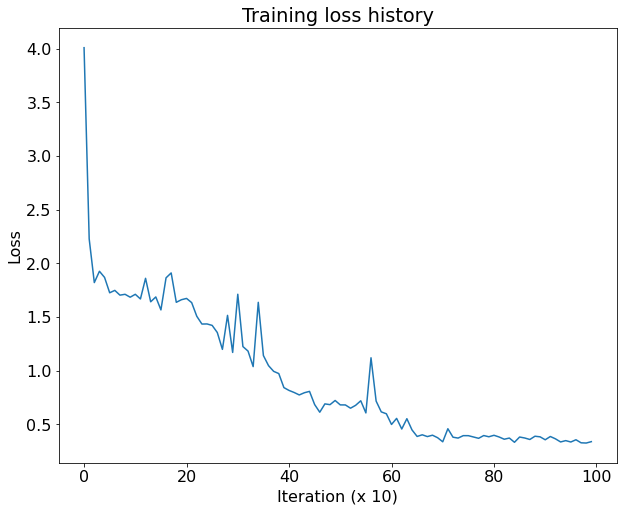

In [26]:
from two_stage_detector import FasterRCNN


# Re-initialize dataset objects for independent debugging.
small_dataset = torch.utils.data.Subset(
    train_dataset,
    torch.linspace(0, len(train_dataset) - 1, steps=BATCH_SIZE * 10).long()
)
small_train_loader = torch.utils.data.DataLoader(
    small_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NUM_WORKERS
)

FPN_CHANNELS = 64
backbone = DetectorBackboneWithFPN(out_channels=FPN_CHANNELS)
rpn = RPN(
    fpn_channels=FPN_CHANNELS,
    stem_channels=[FPN_CHANNELS, FPN_CHANNELS],
    batch_size_per_image=16,
    anchor_stride_scale=8,
    anchor_aspect_ratios=[0.5, 1.0, 2.0],
    anchor_iou_thresholds=(0.3, 0.6),
    pre_nms_topk=400,
    post_nms_topk=80,
)
# fmt: off
faster_rcnn = FasterRCNN(
    backbone, rpn, num_classes=20, roi_size=(7, 7),
    stem_channels=[FPN_CHANNELS, FPN_CHANNELS],
    batch_size_per_image=32,
)
# fmt: on

train_detector(
    faster_rcnn,
    small_train_loader,
    learning_rate=0.01,
    max_iters=1000,
    log_period=10,
    device=DEVICE,
)

## Implementing Inference

Now, follow the instructions in `FasterRCNN.inference` to implement inference.

Visualize the output from the trained model on a few images by executing the next cell, the bounding boxes should be somewhat accurate. They would get even better by using a bigger model and training it for longer.

In [27]:
from a4_helper import inference_with_detector


# Change the loader to have (batch size = 1) as required for inference.
small_train_loader = torch.utils.data.DataLoader(
    small_dataset, batch_size=1, pin_memory=True, num_workers=NUM_WORKERS
)

inference_with_detector(
    faster_rcnn,
    small_train_loader,
    val_dataset.idx_to_class,
    score_thresh=0.2,
    nms_thresh=0.3,
    device=DEVICE,
    dtype=torch.float32,
)

Output hidden; open in https://colab.research.google.com to view.

## Train a net

**Caution: This takes a very long time! (~ 25 mins)**

Now it's time to train the full Faster R-CNN model on a larger subset of the the training data.
We will train for 2000 iterations; this should take about 25 mins on a K80 GPU.
Note that real object detection systems typically train for 12-24 hours, distribute training over multiple GPUs, and use much faster GPUs. As such our result will be far from the state of the art, but it should give some reasonable results!

> **Note**: while running this cell, you might want to go through next steps. Google Colab would ban your access to GPU for a while (1--7 days) if you are not interactive. If you are banned unfortunately, you may use another Google account.

(Optional) If you train the model longer (e.g., 25K+ iterations), you should see a better mAP. But make sure you revert the code back for grading purposes.

For dummy input images with shape: (2, 3, 224, 224)
Shape of c3 features: torch.Size([2, 64, 28, 28])
Shape of c4 features: torch.Size([2, 160, 14, 14])
Shape of c5 features: torch.Size([2, 400, 7, 7])
[Iter 0][loss: 3.980][loss_rpn_obj: 0.702][loss_rpn_box: 0.237][loss_cls: 3.040]
[Iter 50][loss: 2.068][loss_rpn_obj: 0.606][loss_rpn_box: 0.238][loss_cls: 1.225]
[Iter 100][loss: 1.827][loss_rpn_obj: 0.588][loss_rpn_box: 0.210][loss_cls: 1.029]
[Iter 150][loss: 1.499][loss_rpn_obj: 0.512][loss_rpn_box: 0.257][loss_cls: 0.731]
[Iter 200][loss: 1.429][loss_rpn_obj: 0.639][loss_rpn_box: 0.201][loss_cls: 0.590]
[Iter 250][loss: 1.168][loss_rpn_obj: 0.489][loss_rpn_box: 0.211][loss_cls: 0.469]
[Iter 300][loss: 1.154][loss_rpn_obj: 0.410][loss_rpn_box: 0.237][loss_cls: 0.507]
[Iter 350][loss: 1.351][loss_rpn_obj: 0.363][loss_rpn_box: 0.230][loss_cls: 0.758]
[Iter 400][loss: 1.131][loss_rpn_obj: 0.364][loss_rpn_box: 0.232][loss_cls: 0.536]
[Iter 450][loss: 1.112][loss_rpn_obj: 0.373][loss_rpn_

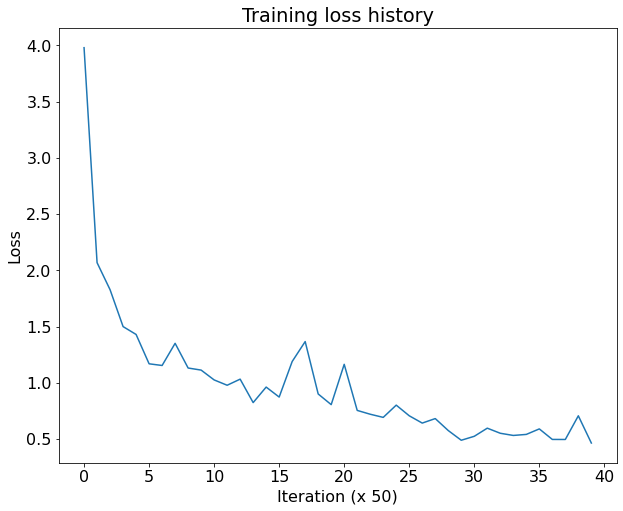

In [28]:
reset_seed(0)

# Slightly larger detector than in above cell.
FPN_CHANNELS = 128
backbone = DetectorBackboneWithFPN(out_channels=FPN_CHANNELS)
rpn = RPN(
    fpn_channels=FPN_CHANNELS,
    stem_channels=[FPN_CHANNELS, FPN_CHANNELS],
    batch_size_per_image=16,
    pre_nms_topk=500,
    post_nms_topk=200  # Other args from previous cell are default args in RPN.
)
# fmt: off
faster_rcnn = FasterRCNN(
    backbone, rpn, num_classes=NUM_CLASSES, roi_size=(7, 7),
    stem_channels=[FPN_CHANNELS, FPN_CHANNELS],
    batch_size_per_image=32,
)
# fmt: on

train_detector(
    faster_rcnn,
    train_loader,
    learning_rate=0.01,
    max_iters=2000,
    log_period=50,
    device=DEVICE,
)

# After you've trained your model, save the weights for submission.
weights_path = os.path.join(GOOGLE_DRIVE_PATH, "rcnn_detector.pt")
torch.save(faster_rcnn.state_dict(), weights_path)

### Inference

VIsualize a few outputs from the full trained model. They may be less accurate than the original Faster R-CNN.
This is expected since our Faster R-CNN model is weaker than expected: we used a smaller model, trained for short duration, and did not include box regression in the second stage.

In [29]:
# Add some imports to run this cell independently of above few cells
# (you will need to run first few cells at the top)
from a4_helper import inference_with_detector
from two_stage_detector import DetectorBackboneWithFPN, RPN, FasterRCNN


# Re-initialize so this cell is independent from prior cells.
# Slightly larger detector than in above cell.
FPN_CHANNELS = 128
backbone = DetectorBackboneWithFPN(out_channels=FPN_CHANNELS)
rpn = RPN(
    fpn_channels=FPN_CHANNELS,
    stem_channels=[FPN_CHANNELS, FPN_CHANNELS],
    batch_size_per_image=16,  # Useless arg for inference.
)
faster_rcnn = FasterRCNN(
    backbone, rpn, num_classes=NUM_CLASSES, roi_size=(7, 7),
    stem_channels=[FPN_CHANNELS, FPN_CHANNELS],
    batch_size_per_image=32,  # Useless arg for inference.
)
faster_rcnn.to(device=DEVICE)

weights_path = os.path.join(GOOGLE_DRIVE_PATH, "rcnn_detector.pt")
faster_rcnn.load_state_dict(torch.load(weights_path, map_location="cpu"))

# Prepare a small val dataset for inference:
small_dataset = torch.utils.data.Subset(
    val_dataset,
    torch.linspace(0, len(val_dataset) - 1, steps=20).long()
)
small_val_loader = torch.utils.data.DataLoader(
    small_dataset, batch_size=1, pin_memory=True, num_workers=NUM_WORKERS
)

inference_with_detector(
    faster_rcnn,
    small_val_loader,
    val_dataset.idx_to_class,
    score_thresh=0.2,
    nms_thresh=0.3,
    device=DEVICE,
    dtype=torch.float32,
)

Output hidden; open in https://colab.research.google.com to view.

## Evaluation

Evaluate your Faster R-CNN by running the code below. If you correctly implemented it, the performance would be around **35 mAP**.

Total inference time: 75.1s
57.08% = aeroplane AP 
40.46% = bicycle AP 
49.02% = bird AP 
18.87% = boat AP 
2.60% = bottle AP 
42.76% = bus AP 
37.37% = car AP 
60.67% = cat AP 
7.46% = chair AP 
26.39% = cow AP 
26.83% = diningtable AP 
44.77% = dog AP 
40.05% = horse AP 
48.18% = motorbike AP 
30.66% = person AP 
9.50% = pottedplant AP 
21.32% = sheep AP 
30.85% = sofa AP 
65.83% = train AP 
16.74% = tvmonitor AP 
mAP = 33.87%
<Figure size 640x480 with 1 Axes>


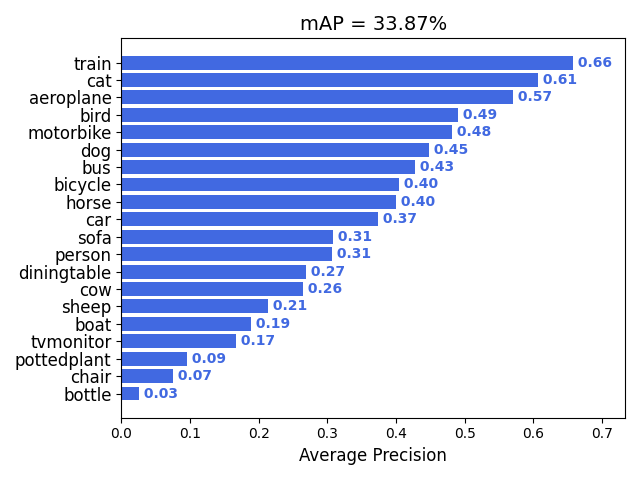

In [30]:
inference_with_detector(
    faster_rcnn,
    val_loader,
    val_dataset.idx_to_class,
    score_thresh=0.2,
    nms_thresh=0.5,
    device=DEVICE,
    dtype=torch.float32,
    output_dir="mAP/input",
)
!cd mAP && python main.py

# This script outputs an image containing per-class AP. Display it here:
from IPython.display import Image
Image(filename="./mAP/output/mAP.png")

# Submit Your Work
After completing both notebooks for this assignment (`pytorch_autograd_and_nn.ipynb` and this notebook, `two_stage_detector.ipynb`), run the following cell to create a `.zip` file for you to download and turn in. 

**Please MANUALLY SAVE every `*.ipynb` and `*.py` files before executing the following cell:**

In [31]:
from common.submit import make_a4_submission

make_a4_submission(GOOGLE_DRIVE_PATH, name, idnum)

Writing zip file to:  /content/drive/MyDrive/연세대/시각인식/A4/insik_cho-2021321148-A4.zip
